In [1]:
import sys
import time

import pickle as pkl
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np


from Extractor import Extractor
from scipy.sparse import coo_matrix,csr_matrix
#import tensorflow as tf
import torch
from utils import *
from model import *
from train import *

from explain import *
import time
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import to_networkx


np.set_printoptions(threshold=sys.maxsize)

In [2]:
from torch_geometric.datasets import TUDataset, Entities
from torch_geometric.data import DataLoader
dataset = TUDataset(root='./dataset/Mutagenicity', name='Mutagenicity', use_node_attr=True)
dataset.len()

4337

In [3]:
train_len = int(0.8 * dataset.len())
test_len = dataset.len() - train_len

In [4]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_len, test_len])

In [5]:
#gcn_model = GCN(dataset, 2, 20)
#torch.load('./checkpoint/gcn_mutag')
gcn_model = ATTGCN(dataset, 2, 20)

In [5]:
gcn_model = torch.load('./MUTAG_search_checkpoint_2/auc_0.9326872275822641')

In [6]:
gcn_model.convs

ModuleList(
  (0): CD_GATConv(40, 20, heads=2)
)

In [7]:
train(gcn_model, train_dataset, test_dataset, max_epoch = 30, lr=0.001, save_model = True)

prepare dataloader
done
Epoch:  0 Avg loss:  0.71447337 ; acc:  0.4488325 ; epoch time:  0.8324930667877197
eval test...
Epoch:  0 Avg loss:  0.69733226 ; acc:  0.43663594 ; epoch time:  0.12323951721191406
saving...


Epoch:  1 Avg loss:  0.68522817 ; acc:  0.5428077 ; epoch time:  0.5593101978302002
eval test...
Epoch:  0 Avg loss:  0.6798838 ; acc:  0.563364 ; epoch time:  0.06796574592590332
saving...


Epoch:  2 Avg loss:  0.67903334 ; acc:  0.5511675 ; epoch time:  0.5220434665679932
eval test...
Epoch:  0 Avg loss:  0.67348504 ; acc:  0.563364 ; epoch time:  0.0686945915222168


Epoch:  3 Avg loss:  0.6693155 ; acc:  0.5546267 ; epoch time:  0.5311906337738037
eval test...
Epoch:  0 Avg loss:  0.665045 ; acc:  0.5645161 ; epoch time:  0.06531095504760742
saving...


Epoch:  4 Avg loss:  0.6532178 ; acc:  0.5736523 ; epoch time:  0.5259571075439453
eval test...
Epoch:  0 Avg loss:  0.649557 ; acc:  0.6152074 ; epoch time:  0.07342863082885742
saving...


Epoch:  5 Avg loss:  0.62

In [10]:
#gcn_model = torch.load('./checkpoint/gcn_mutag_temp')
eval(gcn_model, test_dataset)

Epoch:  0 Avg loss:  0.5037278 ; acc:  0.7557604 ; epoch time:  0.3175218105316162


array(0.7557604, dtype=float32)

In [38]:
#torch.save(gcn_model, './checkpoint/gcn_mutag')

In [12]:
correct = 0
dataset.subgraph = True
dataset.remap = True
#load_model = torch.load('./checkpoint/gcn_mix').to('cuda')
load_model = gcn_model
load_model.eval()
in_correct = []
for idx in select:
    print('index: ', idx)
    data = get_data(dataset, idx).to('cuda')
    pred = load_model.forward(data)
    #print(preds)
    label = data.y.to('cuda')

    _, indices = torch.max(pred, 1)
    #print(pred)
    print(label)
    #print(torch.sum(label))
    print(indices)
    #print(torch.argmax(load_model(data)[0]))
    if (indices[0] == label[0]):
        correct += 1
    else:

        print('incorrect: ', idx)
        in_correct.append(idx)
print(correct)
print(in_correct)

index:  10
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
index:  22
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
index:  25
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
index:  31
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
index:  33
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
index:  41
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
index:  42
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
index:  44
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
index:  45
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
index:  49
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
index:  51
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
index:  65
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
index:  71
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
index:  72
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
index:  79
tensor([0], device='cud

In [14]:
kwargs = {}
kwargs['node_name_list'] = ['C', 'O', 'Cl', 'H', 'N', 'F', 'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']

In [15]:
from utils import *
import torch
from CD_layers import *
import time
from torch_geometric.utils import to_networkx
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

def find_edge(model, dataset, idx, class_idx = None, node_sort = None, topk = None, start_num = 2):
    if node_sort is None:
        node_sort, node_color = print_explain(dataset, model, idx, class_idx = class_idx, visible = False)
    if class_idx is None:
        class_idx = int(dataset[idx].y[0])
    data = get_data(dataset, idx)
    data = data.to(device)
    start_num = start_num
    
    rest = list(node_sort.copy())
    select = set()
    neighbor_nodes = set()
    select_node_progress = []
    edge_index = np.array(dataset[idx].edge_index)

    while len(select) < topk and len(rest) != 0:
        if len(neighbor_nodes) == 0:
            for _ in range(start_num):
                if len(rest) == 0:
                    pass
                select_node = rest[0]
                select.add(select_node)
                rest.remove(select_node)
                # add new neighbor edge
                temp_neighbor_idx = (np.where(edge_index[0] == select_node))[0]
                #print(temp_neighbor_idx)
                for n_idx in temp_neighbor_idx:
                    n = int(edge_index[1][n_idx])
                    if n not in select:
                        neighbor_nodes.add(n)
                try:
                    neighbor_nodes.remove(select_node)
                except:
                    pass
                #print('no neighbor')
                #print('select: ', select)
                #print('neighbor_nodes', neighbor_nodes)
            select_node_progress.append(select.copy())
            
        else:
            # prepare list for score
            check_list = []
            for node in neighbor_nodes:
                group = select.copy()
                group.add((int)(node))
                check_list.append(group)
            #print(check_list)
            class_score = get_score(model, data, mask_list = check_list.copy())
            group_scores = class_score[class_idx]['rel']
            group_rank = np.argsort(group_scores)[::-1]
            print('score: ', group_scores[group_rank[0]])
            #print(group_rank)
            select = check_list[group_rank[0]]
            #print(check_list)
            intersect = select.intersection(neighbor_nodes)
            #print(intersect)
            neighbor_nodes = neighbor_nodes - select
            #print(rest)
            for node in intersect:
                rest.remove(node)
                # add new neighbor edge
                temp_neighbor_idx = (np.where(edge_index[0] == node))[0]
                #print('temp_neighbor_idx', temp_neighbor_idx)
                for n_idx in temp_neighbor_idx:        
                    n = int(edge_index[1][n_idx])
                    if n not in select:
                        neighbor_nodes.add(n)
            select_node_progress.append(select.copy())
        size = max(edge_index[0]) + 1
        adj = np.zeros((size, size))
        edge_pred = []
        for i in range(edge_index.shape[1]):
            r = edge_index[0][i]
            c = edge_index[1][i]
            if r in select and c in select:
                adj[r][c] = 1
                adj[c][r] = 1
            
            if r < c:
                if r in select and c in select:
                    edge_pred.append(1)
                else:
                    edge_pred.append(0)

        adj = preprocess_adj(adj)
    return select,select_node_progress,adj,edge_pred

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def CD_explain(model, dataset, idx = 0, mask_node_list = None, node_range = None):
    """
    idx: idx of graph to explain
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    data = get_data(dataset, idx)
    data = data.to(device)


    mask_list = []
    # generate mask
    node_range = data.x.shape[0] if node_range is None else node_range


    for i in range(node_range):
        if mask_node_list is not None and i in mask_node_list:
            mask_list.append(mask_node_list)
        else:
            mask_list.append([i])
    # forward to explain according to mask list
    class_score = get_score(model, data, mask_list)
    return class_score
def get_score(model, data, input_mask_list, softmax = False):
    #print('========================')
    Binary_mask_list = []
    for i in range(len(input_mask_list)):
        mask_index = [0] * data.x.shape[0]
        for m in input_mask_list[i]:
            mask_index[m] = 1
        Binary_mask_list.append(mask_index)
    
    preds_list = []
    model.eval()
    for mask_index in Binary_mask_list:
        model.zero_grad()
        preds = model.forward(data, CD_explain=True, mask_index = mask_index)
        #print(preds)
        #print(data.y)
        preds['rel'] = preds['rel'].T
        preds['irrel'] = preds['irrel'].T
        #print(preds['irrel'].shape[0])
        #print(dataset.num_classes)
        if softmax:
            preds = CD_softmax(preds, index = torch.tensor([0] * preds['irrel'].shape[0]).to(device))
        #print(preds)
        preds_list.append(preds)
        # need to softmax??

    # rel cd score for each class
    class_score = {}
    for class_idx in range(preds['irrel'].shape[0]):
        class_score[class_idx] = {}
        class_score[class_idx]['rel'] = []
        class_score[class_idx]['irrel'] = []
        for preds in preds_list:
            class_score[class_idx]['rel'].append((float)((preds['rel'][class_idx][0].cpu().detach())))
            class_score[class_idx]['irrel'].append((float)((preds['irrel'][class_idx][0].cpu().detach())))
            #class_score[class_idx]['rel'].append((float)((preds['rel'][0][class_idx].cpu().detach())))
            #class_score[class_idx]['irrel'].append((float)((preds['irrel'][0][class_idx].cpu().detach())))

    return class_score

def print_explain(dataset, model, idx, class_idx = None, visible = True, figsize = None, node_range = None, **kwargs):
    
    class_idx = int(class_idx) if class_idx is not None else (int)(dataset[idx].y[0])
    idx = int(idx)
    begin_time = time.time()
    class_score = CD_explain(model, dataset, idx, node_range)
    
    print('prediction score',(class_score[0]['rel'][0] + class_score[0]['irrel'][0]))
    elapsed = time.time() - begin_time
    node_colors = class_score[class_idx]['rel']
    size_ratio = 1.0 + (node_colors - np.min(node_colors)) / (np.max(node_colors) - np.min(node_colors))
    print('epoch time: ', elapsed)

    if visible:
        if figsize is not None:
            plt.figure(figsize=figsize)
        G = to_networkx(dataset[idx])

        pos = nx.kamada_kawai_layout(G)

        node_sizes = 600 * size_ratio
        node_colors = class_score[class_idx]['rel']


        cmap = plt.cm.coolwarm

        #t = [0, 1, 2, 4, 5, 6, 8, 9, 10, 17]
        #for tt in t:
        #    node_colors[tt] = 0.4264645576477051
        nodes = nx.draw_networkx_nodes(
            G,
            pos,
            node_size=node_sizes,
            node_color=node_colors,
            cmap=cmap,
            edgecolors='blue',
            vmax = max(node_colors) * 1.2,
            #vmin = 0.1
        )
        edges = nx.draw_networkx_edges(
            G,
            pos,
            node_size=node_sizes,
            arrowstyle="-",
            arrowsize=10,
            width=2,
        )
        label_list = {}
        for i in range(dataset[idx].x.shape[0]):
            label_list[i] = str(i)
            if 'node_name_list' in kwargs:
                node_name_idx = int(np.argmax(dataset[idx].x[i]))
                label_list[i] += '' + kwargs['node_name_list'][node_name_idx]

        labels = nx.draw_networkx_labels(G, pos, label_list, font_size=12, font_color="black")
        plt.colorbar(nodes)

        ax = plt.gca()
        ax.set_axis_off()
        #plt.savefig('1')
        plt.show()

    return np.argsort(node_colors)[::-1], node_colors

In [16]:
select = np.load('gt_index.npy')
edge_lists = np.load('edge_lists.npy', allow_pickle = True)
edge_label_lists = np.load('edge_label_lists.npy', allow_pickle=True)

In [19]:
acc_list = []
auc_list = []
node_num_list = []

load_model = gcn_model
#load_model = torch.load('./checkpoint/gcn_mix').to('cuda')
load_model.eval()

all_node_label = []
all_node_color = []
#for idx in range(dataset.len()):
#for idx in range():
for idx in range(1015):
    #idx  = 21
    #if idx in in_correct:
    #    continue
    idx = int(select[idx])
    print('\nindex: ', idx)
    data = dataset[idx]
    #truth_node = np.where(sub_label[:,1] == True)[0]
    #truth_node = get_node_set(sub_edge_label_matrix)
    #if len(truth_node) > 6:
    #    continue
    print('label: ', data.y[0])
    node_sort, node_color = print_explain(dataset, load_model, idx, class_idx = 0, visible = False, figsize = (8,6), **kwargs)
    #_, _, adj, edge_pred = find_edge(load_model, dataset, idx, class_idx = None, node_sort = node_sort, topk = 10, start_num=1)
    #print(_)
    edge_score = Edge_explain(load_model, dataset, edge_lists[idx], idx)
    edge_colors = []
    for i in range(len(edge_score[0]['rel'])):
        edge_colors.append( edge_score[0]['rel'][i])# - edge_score[1]['rel'][i] )
    print('edge sort: ', np.argsort(edge_colors)[::-1])
    auc = roc_auc_score(edge_label_lists[idx],edge_colors)
    print('auc: ', auc)
    auc_list.append(auc)
    print('auc mean: ', np.mean(auc_list))
    #print(roc_auc_score(edge_label_lists[idx][0:-1:2], edge_pred))
    #edge_type(adj, data)
    #node_label = np.array([0] * sub_label.shape[0]


index:  10
label:  tensor(0)
prediction score 0.35607094317674637
epoch time:  0.6780354976654053
have edge_list
edge sort:  [19 18 20 21 15 14  2  3  0  1  4  5 10 11  7  6 13 12 35 34 23 22  8  9
 24 25 40 41 38 39 46 47 28 29 27 26 37 36 48 49 51 50 45 44 30 31 17 16
 42 43 54 56 55 57 33 32 52 53]
auc:  1.0
auc mean:  1.0

index:  22
label:  tensor(0)
prediction score 0.8986745029687881
epoch time:  0.6050589084625244
have edge_list
edge sort:  [26 27 29 28 32 33  0  1  5  4 19 18 21 20 22 23  9  8 12  7  6 14 15 38
 39 13 45 44 40 41 16  3  2 17 10 46 43 42 11 47 35 34 25 24 50 51 30 31
 36 37 48 49]
auc:  1.0
auc mean:  1.0

index:  25
label:  tensor(0)
prediction score 1.091724131256342
epoch time:  0.7392470836639404
have edge_list
edge sort:  [61 60 63 62  6  7 18 19 16 17 30 31  0  1 35 34 28 29  4  5 40 41 10 11
  3  2  8  9 13 12 38 39 22 23 27 26 51 50 49 52 53 48 56 57 59 58 15 14
 36 37 21 20 68 67 66 69 54 55 32 33 64 65 24 25 44 45 46 47 43 42]
auc:  1.0
auc mean:  1.

KeyboardInterrupt: 

prediction score 0.18109309673309326
epoch time:  0.42268919944763184


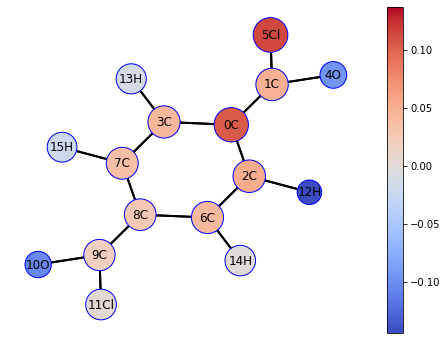

In [20]:
idx = 0
data = dataset[idx]
node_sort, node_color = print_explain(dataset, load_model, idx, class_idx = 0, visible = True, figsize = (8,6), **kwargs)



In [15]:
node_sort

array([ 0, 10,  3,  1,  6,  5,  8,  4, 18, 19, 14, 13,  9,  2,  7, 16, 17,
       12, 15, 11])

In [17]:
def adjacent_process(data):
    '''
    transfer an edge_index to matrix hash map
    '''
    node_num = data.x.shape[0]
    matrix = {}
    for n in range(node_num):
        matrix[n] = []
    

    for i in range(data.edge_index.shape[1]):
        matrix[ int(data.edge_index[0][i]) ].append( int(data.edge_index[1][i]) )

    return matrix

In [18]:
def if_connect(set_1, set_2, A):
    '''
    return if two sets connect to each other
    A is adjacent matrix hash map
    '''
    for i in set_1:
        for j in set_2:
            if j in A[i]:
                return True

    return False

In [19]:
def find_neighbor(node_list, A):
    '''
    find neighbor of node_list
    A : adjacent matrix
    '''

    ans = []
    for n in node_list:
        for ne in A[n]:
            if ne not in node_list:
                ans.append(ne)

    return ans

In [20]:
def merge(comp_list, cand_list, A):
    '''
    merge new candidates node to old comp, aggregate linked group
    comp_list like: [[1,2], [3,4,5], [6]]
    cand_list like: [7,8,9]
    A: adjacent matrix hash map
    '''
    for cand in cand_list:
        new_comp_list = [[cand]]
        for comp in comp_list:
            if if_connect(new_comp_list[0], comp, A):
                new_comp_list[0].extend(comp)
            else:
                new_comp_list.append(comp)

        comp_list = new_comp_list

    return comp_list
        

In [21]:
def agglomerate(load_model, data, percentile = 60, class_idx = 0):
    class_idx = class_idx if class_idx is not None else (int)(dataset[idx].y[0])
    
    
    node_num = data.x.shape[0]
    A = adjacent_process(data)
    # init build, every node score
    mask_list = []
    for i in range(node_num):
        mask_list.append([i])
    scores = get_score(model = load_model, data = data.to('cuda'), input_mask_list = mask_list, softmax = False)[0]['rel']
    #print('++++',scores)
    scores = np.absolute(scores)
    thresh_hold = np.nanpercentile(scores, percentile)
    cand_list = np.where(scores >= thresh_hold)[0].tolist()
    
    comp_list = merge([], cand_list, A)
    print(comp_list)

    # begin add nodes
    comp_all = []
    comp_all_score = []
    for _ in range(500):
        print('###############loop: ', _ )
        # find neibors for each comp
        cand_list = []
        scores = []
        for comp in comp_list:
            neighbors = find_neighbor(comp, A)
            print(comp, ": ", find_neighbor(comp, A))
            # score for each neighbor
            for n in neighbors:
                old_set = comp.copy()
                new_set = comp.copy()
                new_set.append(n)
                #print('old_Set: ', old_set)
                #print('new_Set: ', new_set)
                new_set_score = get_score(model = load_model, data = data.to('cuda'), input_mask_list=[new_set], softmax=False)[class_idx]['rel'][0]
                old_set_score = get_score(model = load_model, data = data.to('cuda'), input_mask_list=[old_set], softmax=False)[class_idx]['rel'][0]
                scores.append(new_set_score - old_set_score)

            cand_list.extend(neighbors)
        print(cand_list)
        print(scores)
        scores = np.absolute(scores)
        thresh_hold = np.nanpercentile(scores, percentile)
        print(thresh_hold)
        cand_list = np.take(cand_list, np.where(scores >= thresh_hold)[0])
        cand_list = np.unique(cand_list)
        print(cand_list)
        print(comp_list)
        # merge 
        comp_list = merge(comp_list, cand_list, A)
        print(comp_list)
        comp_sum = np.sum([ len(c) for c in comp_list])
        #print([ len(a) for c in comp_list])
        #print('comp sum: ', comp_sum)
        comp_all.append(comp_list.copy())
        comp_all_score.append([ get_score(model = load_model, data = data.to('cuda'), input_mask_list = [c], softmax = False)[class_idx]['rel'][0] for c in comp_list])
        if node_num <= comp_sum:
            print('BBBBBBBBBBBBBRRRRRRRRRRRRRRREEEEEEEEEEEEEEKKKKKKKKKKKKKK')
            break
    return comp_all, comp_all_score

In [149]:
data = get_data(dataset, 182)
comp_all,comp_all_score = agglomerate(load_model, data, percentile=65)

[[66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8], [29, 28, 27, 7, 6, 5, 4, 3, 2, 1, 0]]
###############loop:  0
[66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8] :  []
[29, 28, 27, 7, 6, 5, 4, 3, 2, 1, 0] :  []
[]
[]
nan
[]
[[66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8], [29, 28, 27, 7, 6, 5, 4, 3, 2, 1, 0]]
[[66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 26, 25, 24, 23,

In [22]:
import matplotlib
global edges
def hier_explain(dataset, model, idx, class_idx = None, visible = True, figsize = None, percentile = 75, **kwargs):
    global edges
    class_idx = int(class_idx) if class_idx is not None else (int)(dataset[idx].y[0])
    idx = int(idx)
    begin_time = time.time()
    data = get_data(dataset, idx)
    comp_all,comp_all_score = agglomerate(model, data, percentile = percentile)
    color_max = max([max(comp_score) for comp_score in comp_all_score]) 
    color_min = min([min(comp_score) for comp_score in comp_all_score]) 
    #color_max = 0.8
    #color_min = -0.8
    print('color range: ', color_max, ' ', color_min)
    node_sizes = 1000
    if visible:

        G = to_networkx(dataset[idx])

        pos = nx.kamada_kawai_layout(G)

        #node_sizes = 600 * size_ratio
        #node_colors = class_score[class_idx]['rel']


        cmap = plt.cm.coolwarm
        if figsize is None:
            fig = plt.figure(figsize = (10 * len(comp_all),10),dpi=100, facecolor="white")
        else:
            fig = plt.figure(figsize = figsize ,dpi=100, facecolor="white")
        
        for layer in range(len(comp_all)):
            plt.subplot(1, len(comp_all), layer+1)

            #find white nodes
            white_nodes = set([n for n in range(data.x.shape[0])])
            comp_list = comp_all[layer]
            comp_score = comp_all_score[layer]


            # print comp nodes
            for i in range(len(comp_list)):
                white_nodes = white_nodes - set(comp_list[i])

                nodes = nx.draw_networkx_nodes(
                    G,
                    pos,
                    nodelist = comp_list[i],
                    node_size = node_sizes,
                    node_color = [comp_score[i]] * len(comp_list[i]),
                    cmap=cmap,
                    #edgecolors='blue',
                    vmax = color_max,
                    vmin = color_min,
                    alpha = 0.6,
                )


                edges = nx.draw_networkx_edges(
                    G.subgraph(comp_list[i]),
                    pos,
                    #node_size=node_sizes,
                    arrowstyle="-",
                    #arrowsize=10,
                    width=20,
                    connectionstyle= 'arc3, rad=0.2',
                    style='-.',
                    alpha=0.3,
                    edge_cmap = cmap,
                    edge_color = [comp_score[i]] * len(G.subgraph(comp_list[i]).edges),
                    edge_vmin = color_min,
                    edge_vmax = color_max,

                    
                )
            
            # print white nodes
            nodes_ = nx.draw_networkx_nodes(
                G,
                pos,
                nodelist = list(white_nodes),
                node_size = node_sizes,
                node_color = ['tab:gray'] * len(white_nodes),
                cmap=cmap,
                #edgecolors='blue',
                vmax = color_max,
                vmin = color_min,
                alpha = 0.3
            )

            edges = nx.draw_networkx_edges(
                G,
                pos,
                #node_size=node_sizes,
                arrowstyle="-",
                #arrowsize=10,
                width=2,
                #connectionstyle= 'arc, rad=0.2',
                style=':',
                alpha=0.3
            )
            label_list = {}
            for i in range(dataset[idx].x.shape[0]):
                label_list[i] = str(i)
                if 'node_name_list' in kwargs:
                    node_name_idx = int(np.argmax(dataset[idx].x[i]))
                    label_list[i] += '' + kwargs['node_name_list'][node_name_idx]

            labels = nx.draw_networkx_labels(G, pos, label_list, font_size=12, font_color="black")
            #plt.colorbar(nodes)

            #ax = plt.gca()
            #ax.set_axis_off()
            #if layer+1 == 1:
            #    continue
            #plt.subplot(1, len(comp_all), layer+1)
            print("layer", layer+1)
        plt.colorbar(nodes)
        plt.show()


[[22, 13], [15, 11], [6], [0]]
###############loop:  0
[22, 13] :  [10, 16]
[15, 11] :  [7, 14]
[6] :  [2, 8, 10]
[0] :  [1, 2, 3]
[10, 16, 7, 14, 2, 8, 10, 1, 2, 3]
[0.04685129225254059, -0.023523569107055664, -0.25508981943130493, 0.038561463356018066, -0.11181089095771313, 0.06646979600191116, 0.05149570107460022, 0.0643487423658371, -0.10440987627953291, 0.050746023654937744]
0.09492485621012747
[2 7]
[[22, 13], [15, 11], [6], [0]]
[[7, 15, 11], [2, 6, 0], [22, 13]]
###############loop:  1
[7, 15, 11] :  [3, 9, 14]
[2, 6, 0] :  [8, 10, 1, 3]
[22, 13] :  [10, 16]
[3, 9, 14, 8, 10, 1, 3, 10, 16]
[0.02754843235015869, 0.0, 0.05845463275909424, 0.1016167402267456, 0.08345814794301987, 0.10272400826215744, 0.08734717220067978, 0.04274216294288635, -0.023523569107055664]
0.08734717220067978
[1 3 8]
[[7, 15, 11], [2, 6, 0], [22, 13]]
[[8, 3, 1, 2, 6, 0, 7, 15, 11], [22, 13]]
###############loop:  2
[8, 3, 1, 2, 6, 0, 7, 15, 11] :  [4, 12, 17, 4, 5, 10, 9, 14]
[22, 13] :  [10, 16]
[4, 12, 

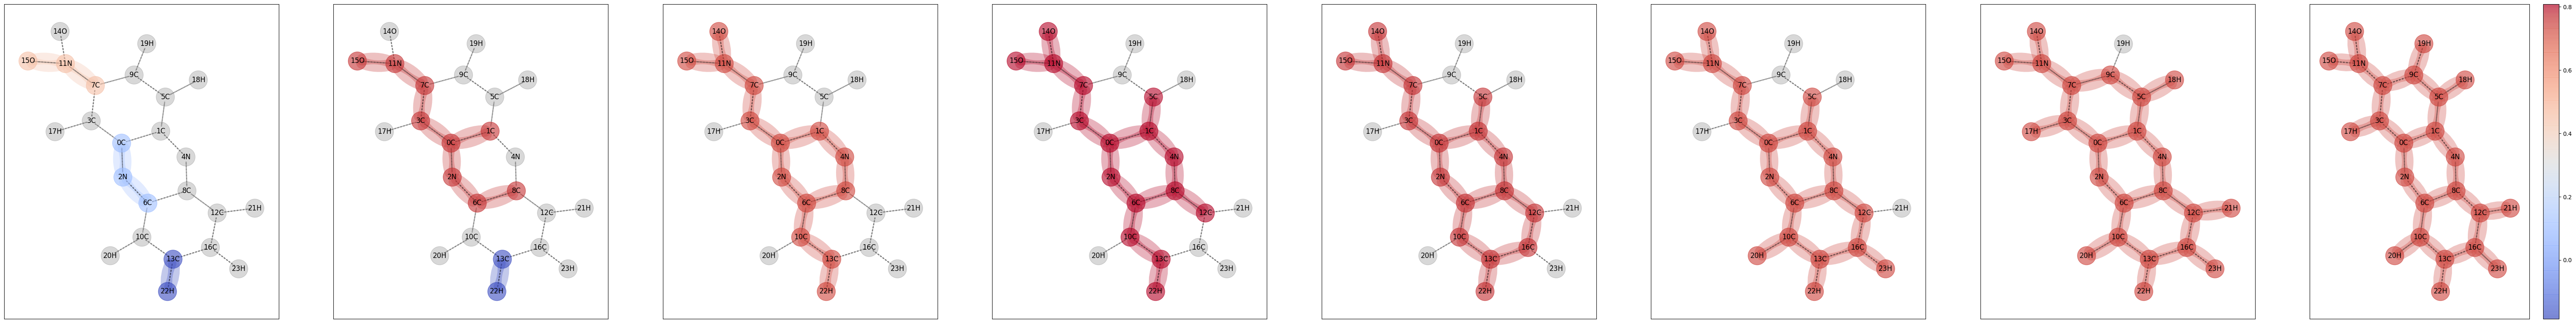

In [33]:
hier_explain(dataset, load_model, idx = 22, class_idx = 0, figsize = None, percentile = 75, **kwargs)

[[16], [15], [14], [8]]
###############loop:  0
[16] :  [9]
[15] :  [9]
[14] :  [9]
[8] :  [4, 10, 11]
[9, 9, 9, 4, 10, 11]
[0.059421151876449585, 0.059421151876449585, 0.04022964835166931, -0.08007267117500305, 0.3676324486732483, 0.33552998304367065]
0.33552998304367065
[10 11]
[[16], [15], [14], [8]]
[[11, 10, 8], [16], [15], [14]]
###############loop:  1
[11, 10, 8] :  [4]
[16] :  [9]
[15] :  [9]
[14] :  [9]
[4, 9, 9, 9]
[-0.12287712097167969, 0.023493915796279907, 0.059421151876449585, 0.04022964835166931]
0.08480353951454164
[4]
[[11, 10, 8], [16], [15], [14]]
[[4, 11, 10, 8], [16], [15], [14]]
###############loop:  2
[4, 11, 10, 8] :  [1, 5]
[16] :  [9]
[15] :  [9]
[14] :  [9]
[1, 5, 9, 9, 9]
[0.006279289722442627, 0.07383203506469727, 0.059421151876449585, 0.023493915796279907, 0.04022964835166931]
0.06230332851409912
[5]
[[4, 11, 10, 8], [16], [15], [14]]
[[5, 4, 11, 10, 8], [16], [15], [14]]
###############loop:  3
[5, 4, 11, 10, 8] :  [2, 13, 1]
[16] :  [9]
[15] :  [9]
[14] 

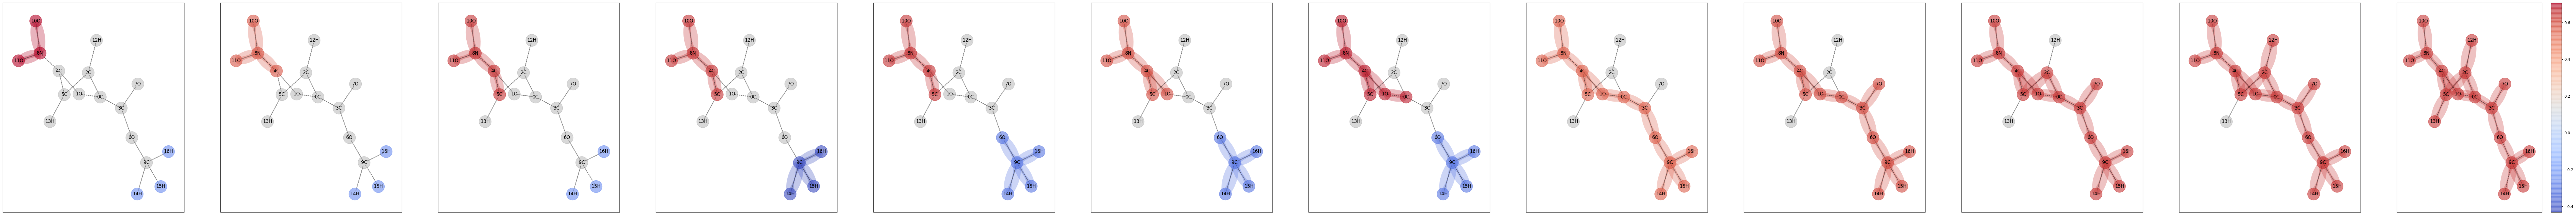

In [26]:
hier_explain(dataset, load_model, idx = select[789], class_idx = 0, figsize = None, percentile = 80, **kwargs)

[[30, 29, 28, 15], [16], [13], [12, 10], [9], [0]]
###############loop:  0
[30, 29, 28, 15] :  [14]
[16] :  [14]
[13] :  [11, 26, 27]
[12, 10] :  [14, 25, 6, 7]
[9] :  [5, 11, 24]
[0] :  [1, 2, 3]
[14, 14, 11, 26, 27, 14, 25, 6, 7, 5, 11, 24, 1, 2, 3]
[0.020074129104614258, 0.015501469373703003, -0.16688752174377441, 0.07169853150844574, 0.0550047904253006, 0.03146407753229141, 0.04449337720870972, 0.09153103083372116, 0.09153112024068832, 0.07680923491716385, 1.4901161193847656e-08, 0.0208263099193573, 0.1199955940246582, 0.08222702145576477, 0.08159342408180237]
0.08210030198097229
[ 1  2  6  7 11]
[[30, 29, 28, 15], [16], [13], [12, 10], [9], [0]]
[[11, 13, 9], [7, 6, 2, 1, 0, 12, 10], [30, 29, 28, 15], [16]]
###############loop:  1
[11, 13, 9] :  [8, 26, 27, 5, 24]
[7, 6, 2, 1, 0, 12, 10] :  [3, 22, 21, 17, 4, 5, 3, 14, 25]
[30, 29, 28, 15] :  [14]
[16] :  [14]
[8, 26, 27, 5, 24, 3, 22, 21, 17, 4, 5, 3, 14, 25, 14, 14]
[0.022405758500099182, 0.08906053751707077, 0.07112152129411697

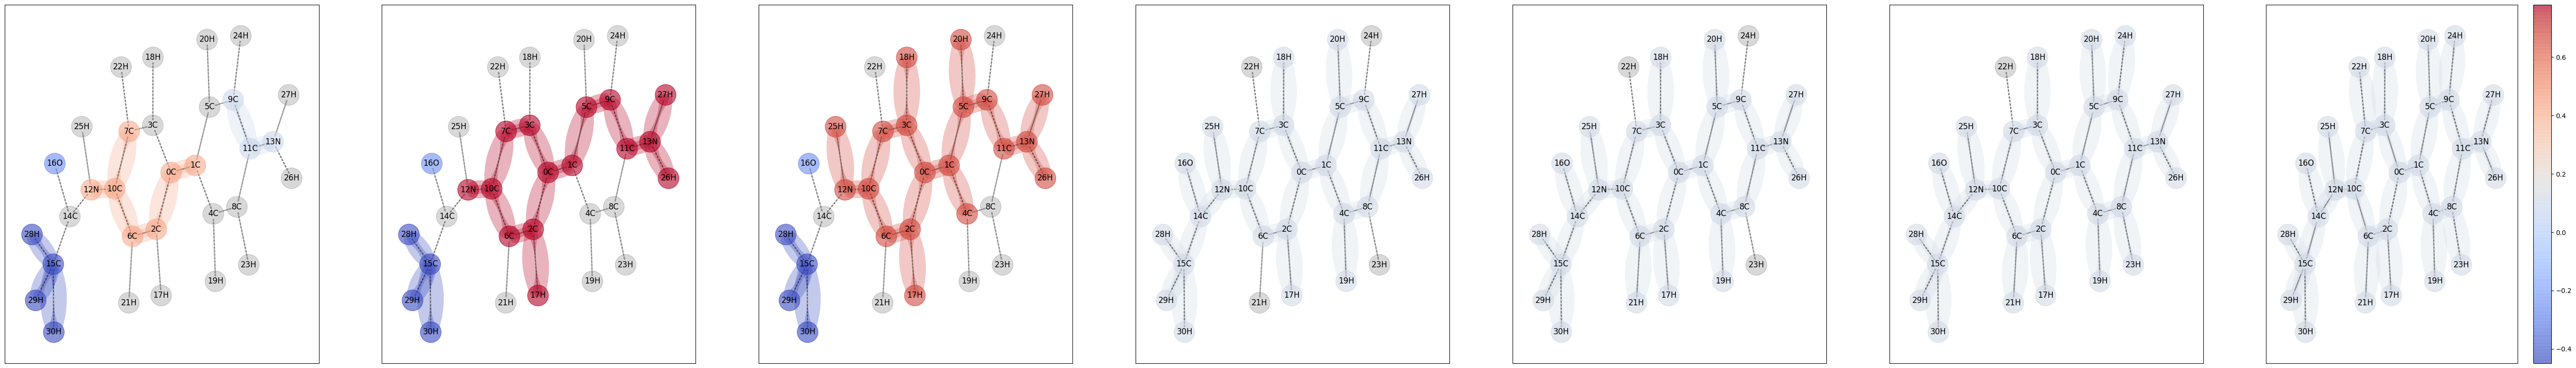

In [27]:
hier_explain(dataset, load_model, idx = 455, class_idx = 0, figsize = None, percentile = 70, **kwargs)

[[20, 19, 5], [16], [15], [6, 3, 2, 0]]
###############loop:  0
[20, 19, 5] :  [1]
[16] :  [14, 27, 28]
[15] :  [12]
[6, 3, 2, 0] :  [7, 8, 17, 1]
[1, 14, 27, 28, 12, 7, 8, 17, 1]
[-0.1777106374502182, -0.11244770884513855, 0.05732613429427147, 0.17836354952305555, -0.17350824177265167, 0.14508427679538727, 0.07356363534927368, 0.06316188722848892, -0.0841665267944336]
0.1621386557817459
[ 1 12 28]
[[20, 19, 5], [16], [15], [6, 3, 2, 0]]
[[28, 16], [12, 15], [1, 20, 19, 5, 6, 3, 2, 0]]
###############loop:  1
[28, 16] :  [14, 27]
[12, 15] :  [10, 14]
[1, 20, 19, 5, 6, 3, 2, 0] :  [4, 7, 8, 17]
[14, 27, 10, 14, 4, 7, 8, 17]
[0.04738466441631317, -0.006199568510055542, -0.01750108227133751, 0.027540603652596474, -0.024984240531921387, 0.3209008350968361, -0.25345689058303833, 0.05516171455383301]
0.05438400954008102
[ 7  8 17]
[[28, 16], [12, 15], [1, 20, 19, 5, 6, 3, 2, 0]]
[[17, 8, 7, 1, 20, 19, 5, 6, 3, 2, 0], [28, 16], [12, 15]]
###############loop:  2
[17, 8, 7, 1, 20, 19, 5, 6, 3, 

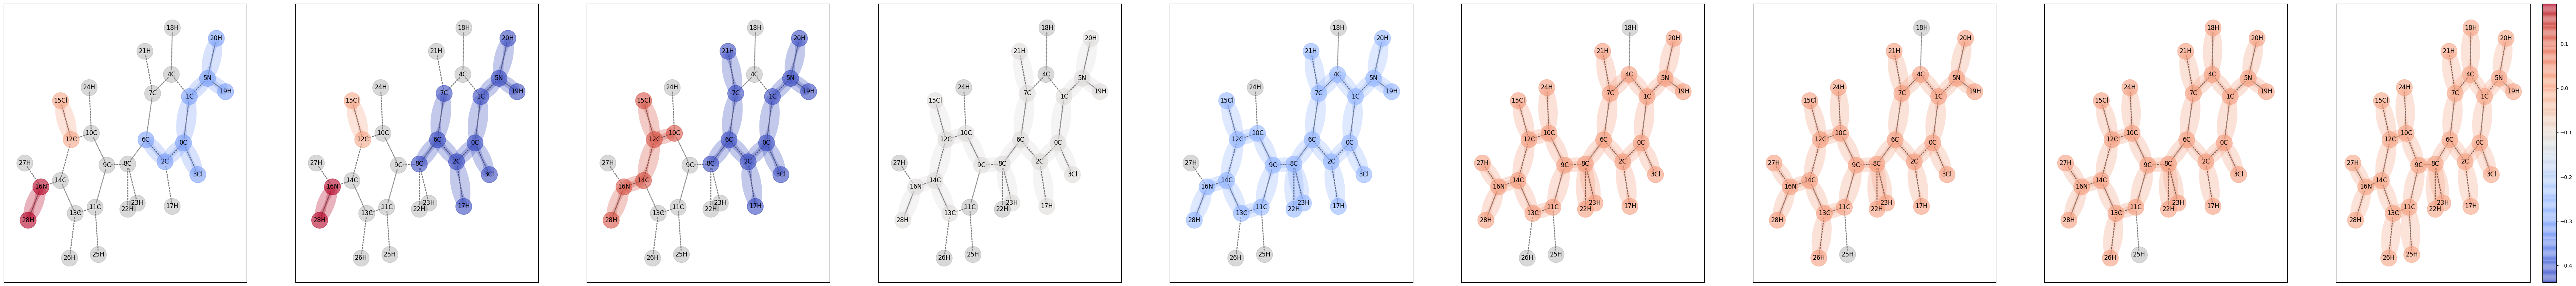

In [30]:
hier_explain(dataset, load_model, idx = 1008, class_idx = 0, figsize = None, percentile = 70, **kwargs)

[[32, 16], [31, 15], [12], [4, 3, 2, 1, 0]]
###############loop:  0
[32, 16] :  []
[31, 15] :  []
[12] :  [9, 27, 28]
[4, 3, 2, 1, 0] :  [7, 8, 6, 20, 5, 19, 17, 18]
[9, 27, 28, 7, 8, 6, 20, 5, 19, 17, 18]
[-0.06302791833877563, 0.016434460878372192, 0.25729408860206604, 0.019500255584716797, -0.010213792324066162, 0.02579173445701599, -0.09815120697021484, -0.022137492895126343, -0.10949578881263733, -0.12188056111335754, -0.09216651320457458]
0.09815120697021484
[17 19 20 28]
[[32, 16], [31, 15], [12], [4, 3, 2, 1, 0]]
[[28, 12], [20, 19, 17, 4, 3, 2, 1, 0], [32, 16], [31, 15]]
###############loop:  1
[28, 12] :  [9, 27]
[20, 19, 17, 4, 3, 2, 1, 0] :  [7, 8, 6, 5, 18]
[32, 16] :  []
[31, 15] :  []
[9, 27, 7, 8, 6, 5, 18]
[-0.1660846769809723, 0.02864256501197815, 0.011182243004441261, 0.011182254180312157, 0.010669343173503876, 0.018026093021035194, -0.17343276739120483]
0.05613098740577688
[ 9 18]
[[28, 12], [20, 19, 17, 4, 3, 2, 1, 0], [32, 16], [31, 15]]
[[18, 20, 19, 17, 4, 3, 2,

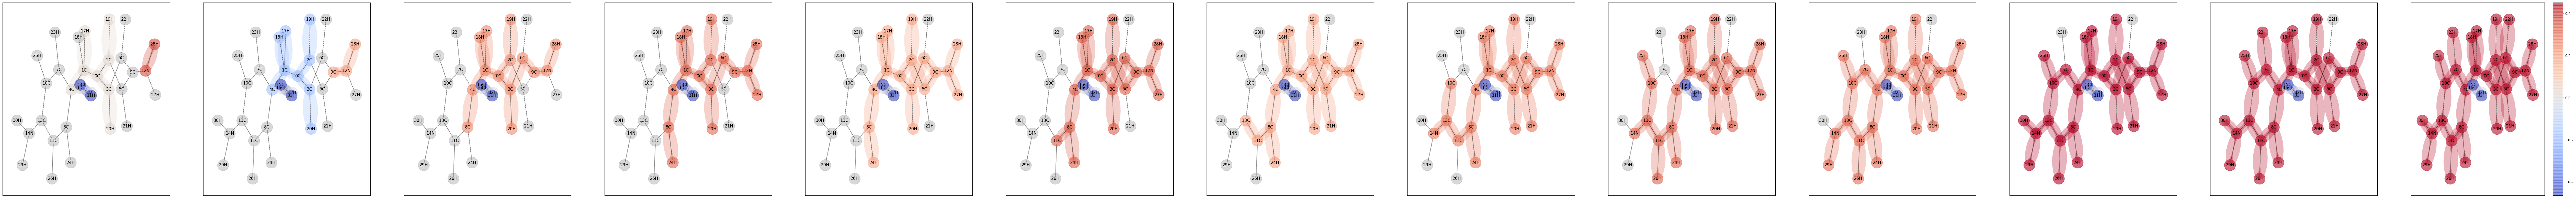

In [32]:
hier_explain(dataset, load_model, idx = 2199, class_idx = 0, figsize = None, percentile = 70, **kwargs)

In [31]:
in_correct

[133,
 182,
 190,
 195,
 455,
 514,
 637,
 640,
 652,
 690,
 815,
 832,
 846,
 865,
 942,
 1008,
 1027,
 1059,
 1075,
 1082,
 1203,
 1329,
 1375,
 1423,
 1482,
 1494,
 1510,
 1561,
 1566,
 1582,
 1655,
 1663,
 1690,
 1770,
 1777,
 1897,
 2060,
 2199,
 2226,
 2307,
 2337,
 2362,
 2364,
 2447,
 2683,
 2688,
 2694,
 2710,
 2858,
 2873,
 2903,
 2925,
 2974,
 3022,
 3121,
 3224,
 3232,
 3254,
 3274,
 3335,
 3376,
 3383,
 3386,
 3401,
 3420,
 3512,
 3532,
 3569,
 3624,
 3654,
 3667,
 3750,
 3828,
 3866,
 4026,
 4063,
 4171,
 4186,
 4208,
 4251,
 4255,
 4261]

In [90]:
# 110 good sample select 789

prediction score -0.16561338305473328
epoch time:  2.4838054180145264


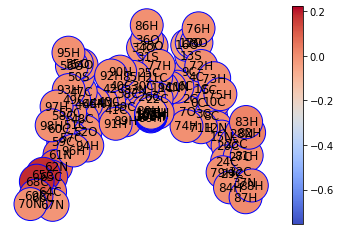

(array([ 68,  65,  63,  69,  62,  61,  28,  66,  64,  82,  83,  88,  87,
         59,  10,  12,  51,  11,  53,  20,  30,  29,  48,  27,  26,   8,
         24,  23,  57,  49,  32,  47,  33,  45,  44,  43,  42,  58,  41,
         40,  39,  38,  37,  14,  15,  19,  46,   0,  60,  96,  90,  91,
         92,  93,  94,  95,  97,  21,  98,   5,   4,   3,   2,   1,  89,
         86,  85,  75,   6,  70,  71,  72,  73,  84,  74,  76,  77,  78,
         79,  80,  81,  22,  25,  54,  52,   7,   9,  13,  50,  31,  67,
         55,  35,  34,  36,  56,  18,  16, 101, 103, 100, 105, 104, 102,
         17,  99]),
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -0.002873759251087904,
  0.0,
  -0.004029902629554272,
  0.0,
  0.0,
  0.0,
  -0.010144510306417942,
  0.0,
  0.0,
  -0.03936811164021492,
  -0.05612035468220711,
  -0.018450843170285225,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -0.0021967808715999126,
  0.0,
  0.0,
  0.050163693726062775,
  0.0,
  0.0,
  -0.010144511237740517,
  0.0,
  0.0

In [137]:
print_explain(dataset, load_model, idx=133, class_idx = 0, **kwargs)